In [1]:
from pdf2image import convert_from_path
import cv2
import pytesseract
import os
import pandas as pd
import re
from tqdm import tqdm
from collections.abc import Iterable
import glob
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = os.path.abspath(os.getcwd())+ "/Tesseract-OCR/tesseract.exe"

In [6]:
def extract(file):
    pdf_file=file.split('\\')[-1]
    
    pages = convert_from_path(file,
                                500, fmt = "jpeg",use_cropbox=True, jpegopt = {"quality":100, "progressive":True,"optimize":True}, 
                                thread_count = 120, transparent = True, grayscale = True,first_page=1,last_page=4,
                                poppler_path=os.path.abspath(os.getcwd())+ "/Release-21.03.0/poppler-21.03.0/Library/bin")
    
    directory=os.getcwd()
    
    page_list = [] 
    counter = 1
    for page in pages:
        filename = "page_" + str(counter) + ".jpg"
        page_list.append("page_" + str(counter) + ".jpg")
        page.save(filename, 'JPEG')
        counter = counter + 1
    filelimit = counter - 1
    outpath = directory +"\\text_data"
    #print(outpath)
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    # outfile = directory +"\text_data/"+ pdf_file[:-4] +".txt"
    outfile = directory +"\\text_data\\"+ pdf_file[:-4] +".txt"
    
    f = open(outfile, "w")

    for i in range(1,counter):
        filename = cv2.imread("page_" + str(i) + ".jpg",0)
        thresh  = cv2.threshold(filename, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        inverted_composite = 255 - thresh
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        close = cv2.morphologyEx(inverted_composite, cv2.MORPH_CLOSE, kernel)
        result = 255 - close
        text = pytesseract.image_to_string(result[400:5400][:], config='-l eng --oem 1 --psm 6')
        f.write(text)               

    f.close()
    
    location = ''
    for page in page_list:
            pages = page
            path = os.path.join(location, pages) 
            os.remove(path)
    return

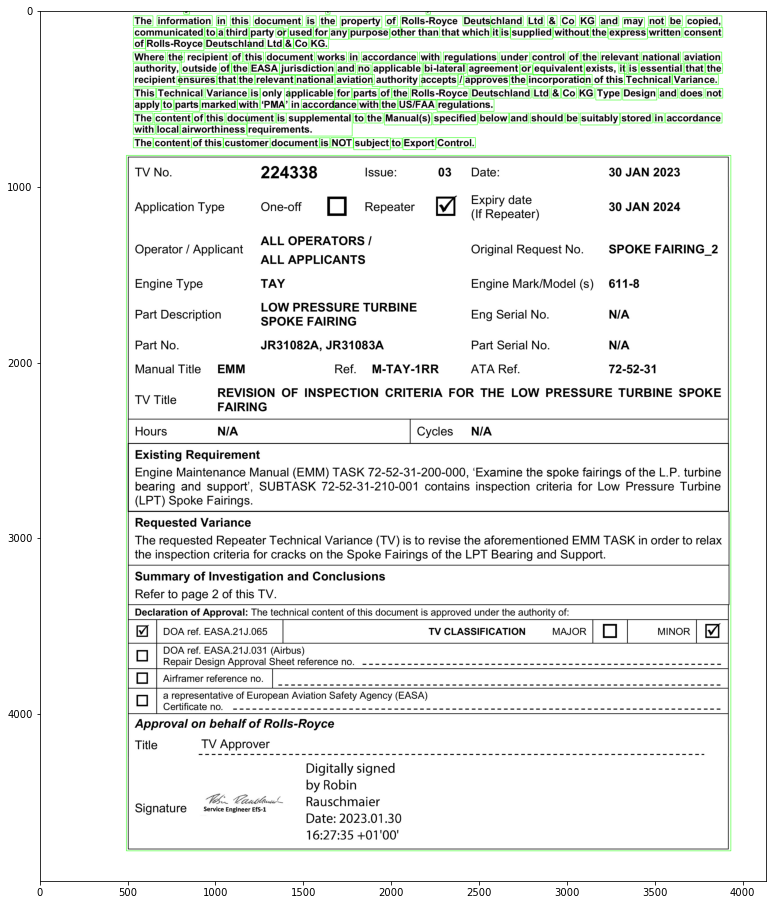

In [33]:
image = cv2.imread(r"C:\Users\U6661132\Documents\Notebooks\SIS\OCR\page_1.jpg")[450:5400][:]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

plt.figure(figsize=(23,16))
plt.imshow(thresh)
plt.imshow(dilate)
plt.imshow(image)

## Tests

In [ ]:
for f in glob.glob('./TV_pdfs/*.pdf'):
    print(f)
    extract(f)
    print("Done")

In [54]:
fi = "TV248256_Iss02_Distribute"
#TV232581.pdf
#RTV233272_Issue 01.pdf
#TV234408 - Issues with L and i - fixed
#RTV233049_Iss01
#TV233418_Iss01_Ver01_CS
#RTV234269_CustomerCopy

In [9]:
extract(r'C:\Users\U6661132\Documents\Data\New TV\RTV\{}.pdf'.format(fi))

PDFPageCountError: Unable to get page count.
I/O Error: Couldn't open file 'C:\Users\U6661132\Documents\Data\New TV\RTV\FRSB315 FLY SHEET1.pdf': No error.


In [115]:
with open(r'C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\{}.txt'.format(fi)) as f:
    content=f.readlines()

content=[x.lower().strip() for x in content]
tv=-1
tv_flag=0
ex_req=-1
ex_req_flag=0
req_var=-1
req_var_flag=0
summary=-1
summary_flag=0
br_start=-1
br_end=-1
br_start_flag=0
br_end_flag=0
sum_cont = 0

for i in range(len(content)):
    if((content[i].find('tv no.')!=-1 or content[i].find('tvno.')!=-1 or content[i].find('technical variance no')!=-1) or (content[i].find('tivno')!=-1)  and tv_flag==0):
        tv=(i)
        tv_flag=1
    if(content[i].find('tass')!=-1 and br_start_flag==0):
        br_start=i
        br_start_flag=1
    if(content[i].find('continuation sheet')!=-1 and br_end_flag==0):
        br_end=i
        br_end_flag=1
try:        
    summary = [i for i in range(len(content)) if re.search('summary of invest', content[i])][-1]
    summary_flag = 1
except:
    summary_flag = 0
try: 
    ex_req = [i for i in range(len(content)) if re.search('existing requ', content[i])][-1]
    ex_req_flag = 1
except:
    ex_req_flag = 0
try:
    req_var = [i for i in range(len(content)) if re.search('requested var', content[i])][-1]
    req_var_flag = 1
except:
    req_var_flag=0
    
if content[summary+1].find('continuation page')!=-1 or content[summary+1].find('continuation sheet')!=-1:
    sss = summary
    summary = [i for i in range(len(content)) if re.search('continuation page', content[i]) or re.search('summary of invest', content[i]) or re.search('continuation sheets', content[i])][-1]
    sum_cont = 1
    
if content[summary+1].find('page 2')!=-1 or content[summary+1].find('see page')!=-1 or content[summary+1].find('next page')!=-1:
    sss = summary
    summary = [i for i in range(len(content)) if re.search('summary of invest', content[i])][-1]
    print(summary)
    sum_cont = 1
    
mx=0
mx_i=-1
pg_l = -1
pg = 0

if not sum_cont:
    for i in range(1,min(50,len(content)-summary)):
        ls_match=set('changes made reflected strikethrough texts deleted instructions are reflected italics made reflected bold underlined deletions marked strikethrough detailed following pages below :'.split(' '))
        temp_content=set(content[summary+i].split(' '))
        match=len(ls_match.intersection(temp_content))

        pg_match = set('pictures of damage following pages below detailed :'.split(' '))
        mat_pg=len(pg_match.intersection(temp_content))

        if(match>=mx):
            mx_i=i
            mx=match
        if(mat_pg>=pg):
            pg_l = i
            pg = mat_pg

    mx_i = max(pg_l,mx_i)

    if content[summary+mx_i-1].find(':') != -1:
        mx_i-=1

else: 
    for i in range(1,min(50,len(content)-summary)):
        ls_match=set('pictures of damage below annotate the engine'.split(' '))
        temp_content=set(content[summary+i].split(' '))
        match=len(ls_match.intersection(temp_content))


        if(match>=mx):
            mx_i=i
            mx=match


ls_final=[('ex_req',ex_req),('req_var',req_var),('summary',summary),('br_start',br_start)]
ls_final=sorted(ls_final,key=lambda x: x[1])

d={
    'ex_req':[ex_req+1],
    'req_var':[req_var+1],
    'summary':[summary+1,summary+mx_i]
}
    
if not sum_cont:
    if (br_start<req_var and br_start>ex_req):
        d['ex_req'].append(br_start)
        d['req_var'].append(summary)  

    elif(br_start<req_var and br_start<ex_req):
        d['ex_req'].append(req_var)
        d['req_var'].append(summary)

    else:
        d['ex_req'].append(req_var)
        d['req_var'].append(br_start)
else:
    if (br_start<req_var and br_start>ex_req):
        d['ex_req'].append(br_start)
        d['req_var'].append(sss)  

    elif(br_start<req_var and br_start<ex_req):
        d['ex_req'].append(req_var)
        d['req_var'].append(sss)

    else:
        d['ex_req'].append(req_var)
        d['req_var'].append(br_start)

tv_no=re.findall(r'(\d{5,6})', content[tv])
if len(tv_no)==0:
    s = ''
    for i in content[tv].split(':')[1:] :
        s += i.replace('date','').replace(' ','').strip()+' '
    tv_no=re.findall(r'(\d{3}[-]\d{5})', s)
    
if ex_req_flag:
    req=" ".join(content[d['ex_req'][0]:d['ex_req'][1]])
else:
    req = 'N/A'
    
if req_var_flag:
    var=" ".join(content[d['req_var'][0]:d['req_var'][1]])
else:
    var = "N/A"
    
if summary_flag:
    summ=" ".join(content[d['summary'][0]:d['summary'][1]])
    r = summ[summ.find('rolls-royce plc proprietary'):summ[summ.find('rolls-royce plc proprietary'):].find('continuation sheet')+summ.find('rolls-royce plc proprietary')+len("continuation sheet ")]
    summ = summ.replace(r,'')
else:
    summ ='N/A'
    
if req=='' and var!='':
    req = 'Included in Requested Variance'
#If summary in req_var
ll = re.findall(r'summary of investigation and conclusions',var)
print(summ,'\n \n',var,'\n \n',ll)

        
if ll and 'page 2' not in var and 'continuation sheet' not in var:
    summ_temp = ''.join(var.split(ll[0])[-len(ll):]).replace('(continued...)','')
    var = var.split(ll[0])[0]
    if 'refer to' in summ_temp:
        summ = summ_temp

try:    
     var = var[:var.index('declaration of approval')]
except:
     var = var
        
try:    
    if 'technical variance is accepted' in summ:
        summ = summ[:summ.index('technical variance is accepted')]
    elif 'bold and underlined' in summ:
        summ = summ[:summ.index('bold and underlined')]
    elif 'pictures of damage' in summ:
        summ = summ[:summ.index('pictures of damage')]
        
except:
     summ = summ

issue 2 of this tv248256 corrects an error in trentxwb-a-72-32-11-18a01-169a-b step 1.16.7.6. changes have been denoted with change bars. issue 2 of this tv248256 completely supersedes tv248256 issue 1. engineering evaluation has concluded that it is acceptable to incorporate the contents of this tv into the em. the engine manual is to be revised in accordance with tpcr cr:db-3923 dated 25 oct 2022. pending formal manual revision, this repeater technical variance is issued to authorise airmotives and repair organisations to work to the intent of the tpcr with immediate effect. this technical variance may be applied until 25-oct-2023. after 25-oct-2023, the affected components or assemblies may continue in service until the next shop visit exposure at which time they should be re-assessed to the manual requirements. this technical variance is accepted subject to compliance with the following instructions / requirements: e accomplish the following em tasks in conjunction with the followi

In [116]:
var,re.findall(r'summary of investigation and conclusions',var)

('this technical variance is to request for the advance issuance of tpcr cr:db-3923 to amend lp/ip bearing & support assembly build and balance instructions in the above em tasks. summary of investigation and conclusions refer to continuation sheets. ',
 ['summary of investigation and conclusions'])

In [117]:
print("TVN :")
print(tv_no[0],'\n')
print("Existing Requirement :")
print(req,'\n')
print("Requested Variance :")
print(var,'\n')
print("Summary of Investigation and Conclusions :")
print(summ)

TVN :
248256 

Existing Requirement :
trentxwb-a-72-32-11-18a01-169a-b; trentxwb-b-72-32-11-18a01-169a-b 

Requested Variance :
this technical variance is to request for the advance issuance of tpcr cr:db-3923 to amend lp/ip bearing & support assembly build and balance instructions in the above em tasks. summary of investigation and conclusions refer to continuation sheets.  

Summary of Investigation and Conclusions :
issue 2 of this tv248256 corrects an error in trentxwb-a-72-32-11-18a01-169a-b step 1.16.7.6. changes have been denoted with change bars. issue 2 of this tv248256 completely supersedes tv248256 issue 1. engineering evaluation has concluded that it is acceptable to incorporate the contents of this tv into the em. the engine manual is to be revised in accordance with tpcr cr:db-3923 dated 25 oct 2022. pending formal manual revision, this repeater technical variance is issued to authorise airmotives and repair organisations to work to the intent of the tpcr with immediate e

## Modified read_text func:

In [2]:
def read_text(file):
    with open(file) as f:
        content=f.readlines()
        
    content=[x.lower().strip() for x in content]
    tv=-1
    tv_flag=0
    ex_req=-1
    ex_req_flag=0
    req_var=-1
    req_var_flag=0
    summary=-1
    summary_flag=0
    br_start=-1
    br_end=-1
    br_start_flag=0
    br_end_flag=0
    sum_cont = 0

    for i in range(len(content)):
        if((content[i].find('tv no.')!=-1 or content[i].find('tvno.')!=-1 or content[i].find('technical variance no')!=-1) or (content[i].find('tivno')!=-1)  and tv_flag==0):
            tv=(i)
            tv_flag=1
        if(content[i].find('tass')!=-1 and br_start_flag==0):
            br_start=i
            br_start_flag=1
        if(content[i].find('continuation sheet')!=-1 and br_end_flag==0):
            br_end=i
            br_end_flag=1
    try:        
        summary = [i for i in range(len(content)) if re.search('summary of invest', content[i])][-1]
        summary_flag = 1
    except:
        summary_flag = 0
    try: 
        ex_req = [i for i in range(len(content)) if re.search('existing requ', content[i])][-1]
        ex_req_flag = 1
    except:
        ex_req_flag = 0
    try:
        req_var = [i for i in range(len(content)) if re.search('requested var', content[i])][-1]
        req_var_flag = 1
    except:
        req_var_flag=0

    if content[summary+1].find('continuation page')!=-1 or content[summary+1].find('continuation sheet')!=-1:
        sss = summary
        summary = [i for i in range(len(content)) if re.search('continuation page', content[i]) or re.search('summary of invest', content[i]) or re.search('continuation sheets', content[i])][-1]
        sum_cont = 1

    if content[summary+1].find('page 2')!=-1 or content[summary+1].find('see page')!=-1 or content[summary+1].find('next page')!=-1:
        sss = summary
        summary = [i for i in range(len(content)) if re.search('summary of invest', content[i])][-1]
        print(summary)
        sum_cont = 1

    mx=0
    mx_i=-1
    pg_l = -1
    pg = 0

    if not sum_cont:
        for i in range(1,min(50,len(content)-summary)):
            ls_match=set('changes made reflected strikethrough texts deleted instructions are reflected italics made reflected bold underlined deletions marked strikethrough detailed following pages below :'.split(' '))
            temp_content=set(content[summary+i].split(' '))
            match=len(ls_match.intersection(temp_content))

            pg_match = set('pictures of damage following pages below detailed :'.split(' '))
            mat_pg=len(pg_match.intersection(temp_content))

            if(match>=mx):
                mx_i=i
                mx=match
            if(mat_pg>=pg):
                pg_l = i
                pg = mat_pg

        mx_i = max(pg_l,mx_i)

        if content[summary+mx_i-1].find(':') != -1:
            mx_i-=1

    else: 
        for i in range(1,min(50,len(content)-summary)):
            ls_match=set('pictures of damage below annotate the engine'.split(' '))
            temp_content=set(content[summary+i].split(' '))
            match=len(ls_match.intersection(temp_content))


            if(match>=mx):
                mx_i=i
                mx=match


    ls_final=[('ex_req',ex_req),('req_var',req_var),('summary',summary),('br_start',br_start)]
    ls_final=sorted(ls_final,key=lambda x: x[1])

    d={
        'ex_req':[ex_req+1],
        'req_var':[req_var+1],
        'summary':[summary+1,summary+mx_i]
    }

    if not sum_cont:
        if (br_start<req_var and br_start>ex_req):
            d['ex_req'].append(br_start)
            d['req_var'].append(summary)  

        elif(br_start<req_var and br_start<ex_req):
            d['ex_req'].append(req_var)
            d['req_var'].append(summary)

        else:
            d['ex_req'].append(req_var)
            d['req_var'].append(br_start)
    else:
        if (br_start<req_var and br_start>ex_req):
            d['ex_req'].append(br_start)
            d['req_var'].append(sss)  

        elif(br_start<req_var and br_start<ex_req):
            d['ex_req'].append(req_var)
            d['req_var'].append(sss)

        else:
            d['ex_req'].append(req_var)
            d['req_var'].append(br_start)

    tv_no=re.findall(r'(\d{5,6})', content[tv])
    if len(tv_no)==0:
        s = ''
        for i in content[tv].split(':')[1:] :
            s += i.replace('date','').replace(' ','').strip()+' '
        tv_no=re.findall(r'(\d{3}[-]\d{5})', s)

    if ex_req_flag:
        req=" ".join(content[d['ex_req'][0]:d['ex_req'][1]])
    else:
        req = 'N/A'

    if req_var_flag:
        var=" ".join(content[d['req_var'][0]:d['req_var'][1]])
    else:
        var = "N/A"

    if summary_flag:
        summ=" ".join(content[d['summary'][0]:d['summary'][1]])
        r = summ[summ.find('rolls-royce plc proprietary'):summ[summ.find('rolls-royce plc proprietary'):].find('continuation sheet')+summ.find('rolls-royce plc proprietary')+len("continuation sheet ")]
        summ = summ.replace(r,'')
    else:
        summ ='N/A'

    if req=='' and var!='':
        req = 'Included in Requested Variance'
    #If summary in req_var
    ll = re.findall(r'summary of investigation and conclusions',var)


    if ll and 'page 2' not in var and 'continuation sheet' not in var:
        summ_temp = ''.join(var.split(ll[0])[-len(ll):]).replace('(continued...)','')
        var = var.split(ll[0])[0]
        if 'refer to' in summ_temp:
            summ = summ_temp

    try:    
         var = var[:var.index('declaration of approval')]
    except:
         var = var

    try:    
        if 'technical variance is accepted' in summ:
            summ = summ[:summ.index('technical variance is accepted')]
        elif 'bold and underlined' in summ:
            summ = summ[:summ.index('bold and underlined')]
        elif 'pictures of damage' in summ:
            summ = summ[:summ.index('pictures of damage')]

    except:
         summ = summ

    return tv_no[0],req,var,summ

def read_rej_text(file):
    tv = 0
    with open(file) as f:
        content=f.readlines()
        
    content=[x.lower().strip() for x in content]
    
    for i in range(len(content)):
        if((content[i].find('tv no.')!=-1 or content[i].find('tvno.')!=-1 or content[i].find('tv')!=-1 or content[i].find('technical variance no')!=-1)):
            tv=(i)
            
    tv_no=re.findall(r'(\d{6})', content[tv])
    if len(tv_no)==0:
        tv_no=re.findall(r'(\d{3}(- )+\d{5})', content[tv])[0]
    return tv_no[0]

In [86]:
len(glob.glob(r'C:\Users\U6661132\Documents\Data\New TV\Tay\*.pdf'))

5

In [4]:
[i for i in glob.glob(r"C:\Users\U6661132\Documents\Data\New TV\*") if 'pdf' not in i]

['C:\\Users\\U6661132\\Documents\\Data\\New TV\\BR700',
 'C:\\Users\\U6661132\\Documents\\Data\\New TV\\RB211',
 'C:\\Users\\U6661132\\Documents\\Data\\New TV\\RTV',
 'C:\\Users\\U6661132\\Documents\\Data\\New TV\\Tay',
 'C:\\Users\\U6661132\\Documents\\Data\\New TV\\trent',
 'C:\\Users\\U6661132\\Documents\\Data\\New TV\\TV Downloaded']

In [7]:
for fol in [i for i in glob.glob(r"C:\Users\U6661132\Documents\Data\New TV\*") if 'pdf' not in i]:
    for f in tqdm(glob.glob(r'{}\*.pdf'.format(fol))):
        extract(f)

100%|████████████████████████████████████████████████████████████████| 891/891 [5:13:44<00:00, 21.13s/it]


In [8]:
outpath = os.getcwd() +"\\tv_excel_data"
if not os.path.exists(outpath):
    os.makedirs(outpath)

ls_o_ls=[]
for f in glob.glob(r'C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\*.txt'):
    fill = f.split('/')[-1].split('.')[0]
    if f.split('\\')[-1].split('.')[0] not in ['FRS5324 7RR','FRS6665 3RR','FRSD100-7RR','LTS71726 Rev 3']:
        try:
            tv,req,var,summ= read_text(f)
            ls_o_ls.append([fill,tv,req,var,summ])
    #     print(tv,"\n")
    #     print(req,"\n")
    #     print(var,"\n")
    #     print(summ,"\n")
        except:
            try:
                ls_o_ls.append([fill,read_rej_text(f),"Rejected TV","Rejected TV"])
            except:
                print(f)


df=pd.DataFrame(ls_o_ls,columns=['file_name','tv_no','existing_requirement',
                                 'requested_variance','summary of investigation and conclusion'])

df.to_excel(os.getcwd()+'\\tv_excel_data\\Tvs-Full_mod_v5.xlsx')

C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\FRSK090-TEN.txt
C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\LoTS252993_Customer.txt
28
C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\RTV244341_customer_copy_02_08_2022.txt
C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\RTV251278 CC.txt
C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\Serviceability TV255346 Rejection_CC.txt
30
C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\TV216707_2 (Digital TV) Customer Copy.txt
28


In [9]:
len(glob.glob(r'C:\Users\U6661132\Documents\Notebooks\SIS\OCR\text_data\*.txt'))

1075

In [10]:
df.shape

(1065, 5)

In [11]:
df.head()

,file_name,tv_no,existing_requirement,requested_variance,summary of investigation and conclusion
0,C:\Users\U6661132\Documents\Notebooks\SIS\OCR\...,204955,"currently, the engine maintenance manual does ...",this technical variance (tv) has been request...,engineering assessment has concluded that the...
1,C:\Users\U6661132\Documents\Notebooks\SIS\OCR\...,235691,trent 7000 check & rectify (cr) manual task 72...,overhaul shop has raised concerns to revise tr...,issue 2 of this repeater tv235691 has been re...
2,C:\Users\U6661132\Documents\Notebooks\SIS\OCR\...,252425,"currently, the trent xwb-97 engine manual does...",the subject technical variance is raised to ad...,issue 2 of the subject tv252425 is done to cor...
3,C:\Users\U6661132\Documents\Notebooks\SIS\OCR\...,252425,"currently, the trent xwb-97 engine manual does...",the subject technical variance is raised to ad...,engineering assessment has concluded that the ...
4,C:\Users\U6661132\Documents\Notebooks\SIS\OCR\...,255924,the existing cleaning procedure dmc trent xwb-...,this requested technical variance is to advanc...,engineering analysis has concluded that the ch...


In [25]:
import pandas as pd
import numpy as np
import spacy
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load pre-trained spaCy model
nlp = spacy.load('en_core_web_lg')

# Define the features (first two columns) and target (third column)
X = df.iloc[:, 0:2]
y = df.iloc[:, 2]

# Convert the text values into word embeddings
X = np.array([nlp(word).vector for word in X.values.ravel()]).reshape(-1, 600)
y = np.array([nlp(word).vector for word in y.values])

In [42]:
# Create a neural network
nn = Sequential()
nn.add(Dense(300, input_dim=600, activation='relu'))
nn.add(Dense(300))
nn.compile(loss='mean_squared_error', optimizer='adam')

# Fit the neural network to the data
nn.fit(X, y, epochs=200,verbose=1)

Epoch 1/200
34/34 [==============================] - 0s 3ms/step - loss: 2.1135
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 1.6981
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 1.1294
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 0.6413
Epoch 5/200
34/34 [==============================] - 0s 2ms/step - loss: 0.5188
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 0.4934
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 0.4877
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 0.4856
Epoch 9/200
34/34 [==============================] - 0s 3ms/step - loss: 0.4764
Epoch 10/200
34/34 [==============================] - 0s 3ms/step - loss: 0.4740
Epoch 11/200
34/34 [==============================] - 0s 2ms/step - loss: 0.4717
Epoch 12/200
34/34 [==============================] - 0s 2ms/step - loss: 0.4704
Epoch 13/200
34/34 [=================

In [45]:
y_pred = nn.predict(X)

34/34 [==============================] - 0s 2ms/step


In [46]:
y_pred,y

(array([[-1.9341855 , -0.94209266,  0.43475893, ..., -1.9905639 ,
         -0.15919168, -0.02259509],
        [-1.9341855 , -0.94209266,  0.43475893, ..., -1.9905639 ,
         -0.15919168, -0.02259509],
        [-1.4227281 ,  0.14006504, -0.42714193, ..., -1.7648716 ,
         -0.77696   ,  0.3711684 ],
        ...,
        [-1.9341854 , -0.94209266,  0.43475893, ..., -1.9905639 ,
         -0.1591917 , -0.02259508],
        [-1.9341854 , -0.94209266,  0.43475893, ..., -1.9905639 ,
         -0.1591917 , -0.02259508],
        [-1.9341854 , -0.94209266,  0.43475893, ..., -1.9905639 ,
         -0.1591917 , -0.02259508]], dtype=float32),
 array([[-1.2387171 , -0.60699886, -0.83904946, ..., -1.6316426 ,
         -0.27633464, -0.23103933],
        [-1.3895285 , -1.7270318 ,  1.3369652 , ..., -1.8146697 ,
          0.304225  , -0.35739166],
        [-0.9498098 ,  1.631699  , -0.7073967 , ..., -2.4655497 ,
         -0.9180195 ,  0.82041764],
        ...,
        [-2.4526281 ,  0.50890243, -0.4

In [47]:
import math
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

In [48]:
c = []
for i,j in zip(y,y_pred):
    c.append(cosine_similarity(i,j))

C:\Users\U6661132\AppData\Local\Temp\ipykernel_6508\3127335649.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return sumxy/math.sqrt(sumxx*sumyy)


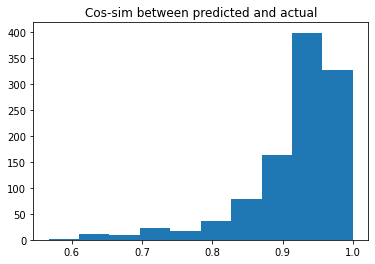

In [49]:
plt.hist(c)
plt.title('Cos-sim between predicted and actual')
plt.show()

In [50]:

# Find the closest words in the vocabulary to the predicted word embeddings
nei = NearestNeighbors(n_neighbors=1)
nei.fit(nlp.vocab.vectors.data)
indices = nei.kneighbors(y_pred, return_distance=False)
predicted_words = [nlp.vocab.strings[nlp.vocab.vectors.most_similar(np.asarray([vector]), n=1)[0][0][0]] for vector in tqdm(y_pred)]
# Add the predicted words to the dataframe
df['Predicted'] = predicted_words

100%|████████████████████████████████████████████████████████████████| 1065/1065 [16:21<00:00,  1.09it/s]


In [51]:
df[['Predicted','summary of investigation and conclusion']]

,Predicted,summary of investigation and conclusion
0,compactification,engineering assessment has concluded that the...
1,compactification,issue 2 of this repeater tv235691 has been re...
2,commodification,issue 2 of the subject tv252425 is done to cor...
3,therefore,engineering assessment has concluded that the ...
4,-,engineering analysis has concluded that the ch...
...,...,...
1060,compactification,issue 1 of this repeater tv has been released...
1061,compactification,engineering assessment has concluded that rtv2...
1062,compactification,a rolls-royce engineering specialist assessmen...
1063,compactification,an engineering raview has concluded that the r...
